## Extracting Dihedral Angles at Triple Junctions from Segmentation Stacks

### Prep

In [1]:
### Imports

import itertools
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from skimage import io
from scipy import spatial
from scipy import interpolate
from scipy import optimize

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

In [2]:
### Load input

#im = io.imread('../Data/Generated/two_intersecting_spheres.tif')
im = io.imread('../Data/Generated/three_intersecting_spheres_aniso.tif')
print(im.dtype, im.shape)

uint8 (200, 400, 400)


In [3]:
### Show input segmentations

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(im[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Object Outlines

In [4]:
### Identify outlines by comparing shifted images

# Pad the image by 1 voxel on all sides
im_pad = np.pad(im, 1, mode='reflect')

# Get possible shifts in all directions
shifts = itertools.product([0,1], repeat=3)

# Check and accumulate differences in shifts
outlines = np.zeros_like(im, dtype=np.bool)
for shift in shifts:
    zs0, ys0, xs0 = [slice(1, None) if s else slice(None) for s in shift]
    zs1, ys1, xs1 = [slice(None,-1) if s else slice(None) for s in shift]
    comparison = im_pad[zs0, ys0, xs0] != im_pad[zs1, ys1, xs1]
    outlines  += comparison[:im.shape[0],  :im.shape[1],  :im.shape[2]]
    outlines  += comparison[-im.shape[0]:, -im.shape[1]:, -im.shape[2]:]  # Symmetry
    
# Re-annotate the cell identities
outlines_id = outlines * im

# Report
print(outlines.dtype, outlines.shape)
print(outlines_id.dtype, outlines_id.shape)

bool (200, 400, 400)
uint8 (200, 400, 400)


In [5]:
### Show identified outlines

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Triple Edges and Triple Junctions

In [6]:
### Find coordinates of all voxels involved in triple junctions

# Get coordinates of all cell outline voxels
# NOTE: Improve this to use the center point of the 2x2x2 element!
OCs = np.array(np.where(outlines)).T  # OCs <- "Outline Coordinates"

# Go through outline coordinates (oc) and find TEs
TEs = []  # TEs <- "Triple Edes"
for OC in OCs:
    selection = im_pad[OC[0]+1:OC[0]+3, OC[1]+1:OC[1]+3, OC[2]+1:OC[2]+3]
    if len(set(selection.flatten())) == 3:
        TEs.append(OC+0.5)
        
# Convert TE list to numpy array
TEs = np.array(TEs)

In [7]:
### Build a dict of TJs structured as: {tuple(cell1_ID, cell2_ID, cell3_ID) : array(TEs, Dimensions)}

# Prepare defaultdict
from collections import defaultdict
TJs = defaultdict(lambda : [[],[],[]])  # TJs <- "Triple Junctions"

# Go through TEs, create IDs, assign coordinates to IDs
for TE in TEs:
    selection = im_pad[np.int(TE[0])+1:np.int(TE[0])+3, 
                       np.int(TE[1])+1:np.int(TE[1])+3, 
                       np.int(TE[2])+1:np.int(TE[2])+3]
    TJ_ID = tuple(sorted(set(selection.flatten())))
    TJs[TJ_ID][0].append(TE[0])
    TJs[TJ_ID][1].append(TE[1])
    TJs[TJ_ID][2].append(TE[2])

# Convert TJ lists to numpy arrays
for key in TJs.keys():
    TJs[key] = np.array(TJs[key]).T

In [8]:
### Show identified TJs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each TJ...
    for TJ_num,TJ_ID in enumerate(TJs.keys()):
        
        # Get the TJ's TEs in the selected z plane
        TEs_in_plane = TJs[TJ_ID][np.floor(TJs[TJ_ID][:,0])==z]
        
        # Plot the points (note the curios way of setting the color!)
        plt.scatter(TEs_in_plane[:, 2], TEs_in_plane[:, 1],
                    c=[TJ_num for _ in range(TEs_in_plane.shape[0])], 
                    cmap='hsv', vmin=0, vmax=len(TJs), s=20)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

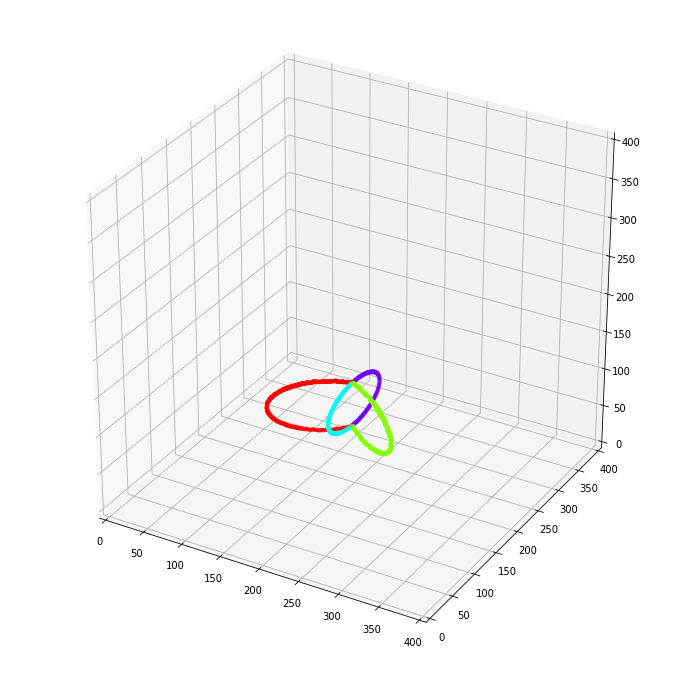

In [9]:
### Show identified TJs as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ in a different color
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.scatter(TJs[TJ_ID][:,2], TJs[TJ_ID][:,1], TJs[TJ_ID][:,0],
               c=[TJ_num for _ in range(TJs[TJ_ID].shape[0])], 
               cmap='hsv', vmin=0, vmax=len(TJs), s=10)

## Also show cell outlines [takes several seconds to render!]
#ax.scatter([c[2] for c in OCs],
#           [c[1] for c in OCs],
#           [c[0] for c in OCs],
#           c='gray', alpha=0.05, linewidth=0, s=5)

# Axis limits
ax.set_xlim([0,400])
ax.set_ylim([0,400])
ax.set_zlim([0,400])  # NOTE: RESULT IS SQUASHED IF RESOLUTION IS NOT CONSIDERED!

# Finish
plt.show()

### Fitting Splines to TJs

Turns out spline fitting requires the input points to be roughly in order along the spline, which isn't guaranteed in our case. Ordering the points happens to be far harder problem than one might imagine (it's a variation of traveling salesman) but luckily it can be solved quite well with a Breadth-First Search (BFS). This solution is partially inspired by Imanol Luengo's answer to [this SO question](https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line).

<font color=red>**FIXME:**</font> This will fail for geometries that exhibit "crossings" or "forks" of any kind. Although that should be very rare/non-existent in the data, a special form of "fork" is the circle. In case of a fully circular TJ, which occurs when two cells neatly touch each other, this will fail (unless some points are removed from the TJ). I couldn't come up with a way of fixing this but divised the `InvalidPathError` to at least pick up on such cases. However, **it may be too stringent** as it is currently implemented!

In [10]:
### Function to reorder TEs along the progression of the TJ

def sort_line_coords(coords, N_neighbors=10, source=None, return_argsort=False):
    """Given a set of coordinates that roughly lie on a 1D curve in mD space
    (but may be in random order), sort the points such that they roughly follow 
    the curve's progression.
    
    Uses a breadth-first search tree on a nearest-neighbor graph of the coords,
    which happens to result in the best possible sort. Does not work as intended
    for closed curves and curves that form any kind of fork or crossing; an 
    Error is raised in such cases.
    
    Parameters
    ----------
    coords : array of shape (N_points, M_dimensions)
        Coordinates of points roughly lying on a point in M-dimensional space.
    N_neighbors : int, optional, default 10
        Number of nearest neighbors to include for each graph. If this is set
        too low, connected components may form and no complete solution is
        possible (raises an Exception). If this is set too high, the resulting
        sort is very imprecises. The ideal value must be determined empirically.
        When used to prepare TJs for spline fitting in the context of pyCFI, the
        default (10) is a reasonably choice and the outcome is largely robust
        to changes between values of 5 and 20.
    source : None or int, optional, default None
        The source is a point at one of the two ends of the line. If None, the
        point is automatically determined by testing all different points and 
        selecting the one that yields the best sort (by minimizing the resulting
        path distance). If source is an int, it indexes into coords to specify
        the end point from which the sort is constructed. This saves a lot of
        time compared to the automated search, especially if there are many
        points, however it requires prior knowledge of the end point.
    return_argsort : bool, optional, default False
        If True, the index array that sorts the points into the best order is 
        returned as a second result. Otherwise, only a sorted version of coords 
        is returned.
    
    Returns
    -------
    sorted_coords : array of shape (N_points, M_dimensions)
        The same set of points as in the input coords but sorted along the
        curve's progression in space.
    best_path : array of shape (N_points,)
        Index array that sorts points along the curve's progression in space. 
        Only returned if return_argsort is set to True.
        
    Exceptions
    ----------
    InvalidPathError : If the curve is closed or contains forks/crossings, the
        sort fails, which is reflected in the fact that the final path will
        contain steps that do not have corresponding edges on the graph. In
        this case, InvalidPathError is raised. This may also occur under other
        dubious circumstances, e.g. if the input data is not a curve at all 
        or if it is a very broad curve or if N_neighbors is too low.
    """
    
    # Get pairwise distances (if needed)
    if source is None:
        dists = spatial.distance.squareform(spatial.distance.pdist(coords))
    
    # Get nearest neighbors
    kdtree  = spatial.cKDTree(coords)
    _, KNNs = kdtree.query(coords, k=N_neighbors)
    
    # Build adjacency matrix
    adj_M = np.zeros((coords.shape[0], coords.shape[0]), dtype=np.bool)
    for i,N in enumerate(KNNs):
        adj_M[i,N] = True
    
    # Construct networkx graph
    G = nx.from_numpy_array(adj_M)
    if not nx.is_connected(G):
        raise Exception('sort_line_coords: adjacency graph is not fully connected!')
     
    # If a source node is given, just get its BFS tree
    if source is not None:
        best_path = list(nx.bfs_tree(G, source))
        
    # Otherwise, find the best BFS tree from all sources
    if source is None:
        paths = []
        costs = []
        for n in G.nodes():

            # Get BFS tree
            path = list(nx.bfs_tree(G, n))

            # Get sum of all distances within tree
            cost = 0.0
            for n0,n1 in zip(path, path[1:]):
                cost += dists[n0, n1]

            # Keep results
            paths.append(path)
            costs.append(cost)

        # Select the best solution
        best_path = paths[np.argmin(costs)]
    
    # Hm
    for p1,p2 in zip(best_path, best_path[1:]):
        if not G.has_edge(p1,p2):
            class InvalidPathError(Exception): pass
            raise InvalidPathError("The sort path uses an edge that is not on the graph. "+
                                   "This should not happen and probably implies that the "+
                                   "curve is cyclical or has a fork/crossing.")
    
    # Sort coords and return
    if return_argsort:
        return coords[best_path], best_path
    else:
        return coords[best_path]

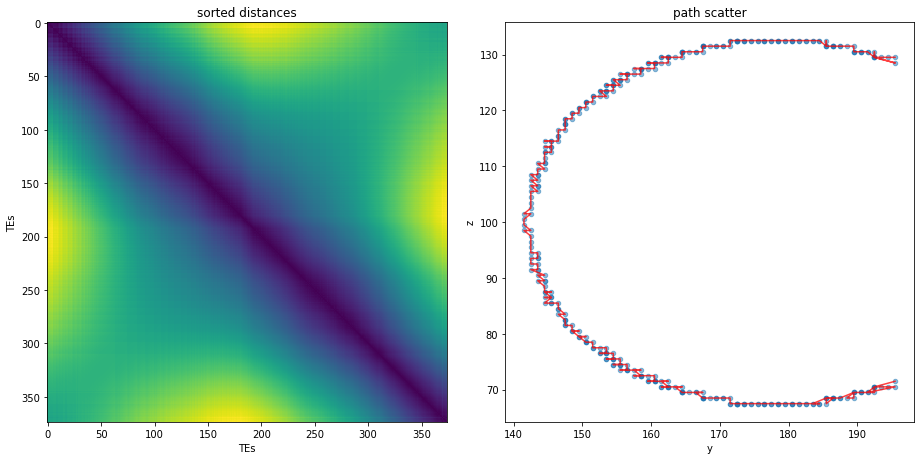

In [11]:
### A quick test of the TJ sorting

# Grab TJ and compute sort
TJ = TJs[list(TJs.keys())[0]]
sorted_TJ = sort_line_coords(TJ)

# Get sorted pairwise distances
sorted_dists = spatial.distance.squareform(spatial.distance.pdist(sorted_TJ))

# Plot pairwise distances
fig, ax = plt.subplots(1, 2, figsize=(13,6.5))
ax[0].imshow(sorted_dists)
ax[0].set_title("sorted distances")
ax[0].set_xlabel('TEs'); ax[0].set_ylabel('TEs')

# Plot path/tree on scatter
ax[1].scatter(TJ[:,1], TJ[:,0], s=20, alpha=0.5)
ax[1].plot(sorted_TJ[:,1], sorted_TJ[:,0], c='r', alpha=0.75)
ax[1].set_title("path scatter")
ax[1].set_xlabel('y'); ax[1].set_ylabel('z')

# Done
plt.tight_layout()
plt.show()

In [12]:
### Wrapper for spline fitting; allows handling exceptions

def wrap_splprep(coords, k=3, verbose=False):
    
    # Fit the spline and unpack the (weirdly packaged) results
    tcku, fp, ier, msg = interpolate.splprep(coords.T, k=k, full_output=True)
    tck, u = tcku

    # Report the results
    if verbose:
        print ('\nt (knots, tck[0]):\n' , tck[0])
        print ('\nc (coefficients, tck[1]):\n' , tck[1])
        print ('\nk (degree, tck[2]):' , tck[2])
        print ('\nu (evaluation points):\n', u)
        print ('\nfp (residual error):', fp)
        print ('\nier (error code; success is ier<=0):', ier)
        print ('\nmsg (message from FITPACK):\n', msg)
        
    # Raise an error if FITPACK indicates failure
    if ier > 0:
        raise Exception('ier is >0, indicating that FITPACK failed somehow. '+
                        'The message from FITPACK was:\n'+msg)
        
    # Return the only result relevant to spline evaluation
    return tck

In [13]:
### Perform sorting and spline fitting on all TJs

TJs_splord = {}  # Index array to sort points along curve
TJs_spltck = {}  # tck values of the spline
TJs_splev  = {}  # TJ coordinates from spline evaluation
TJs_spltng = {}  # tangent vectors to the spline
for TJ_ID in TJs.keys():
    
    # Sort coords along the line
    TJs[TJ_ID], TJs_splord[TJ_ID] = sort_line_coords(TJs[TJ_ID], return_argsort=True)
    
    # Perform spline fitting
    tck = wrap_splprep(TJs[TJ_ID])
    TJs_spltck[TJ_ID] = tck
    
    # Evaluate the spline along regular intervals
    ev = interpolate.splev(np.linspace(0.0, 1.0, 1000), tck)
    ev = np.array(ev).T
    TJs_splev[TJ_ID] = ev
    
    # Also evaluate with slight deviation forward and backward
    evD1 = np.array(interpolate.splev(np.linspace(0.0, 1.0, 1000)+10e-2, tck)).T
    evD2 = np.array(interpolate.splev(np.linspace(0.0, 1.0, 1000)-10e-2, tck)).T
    
    # Approximate the tangent vector as the sum of the deviatory vectors
    tangent_vec = (evD1 - ev) + (ev - evD2)
    TJs_spltng[TJ_ID] = tangent_vec

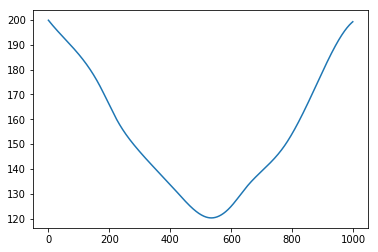

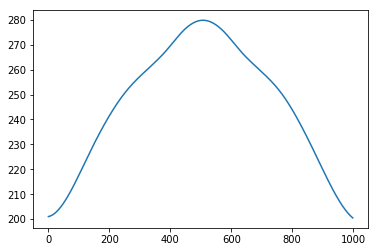

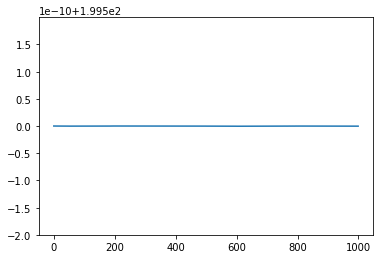

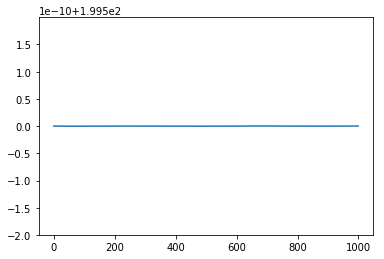

In [14]:
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    plt.plot(TJs_splev[TJ_ID][:,2])
    plt.show()

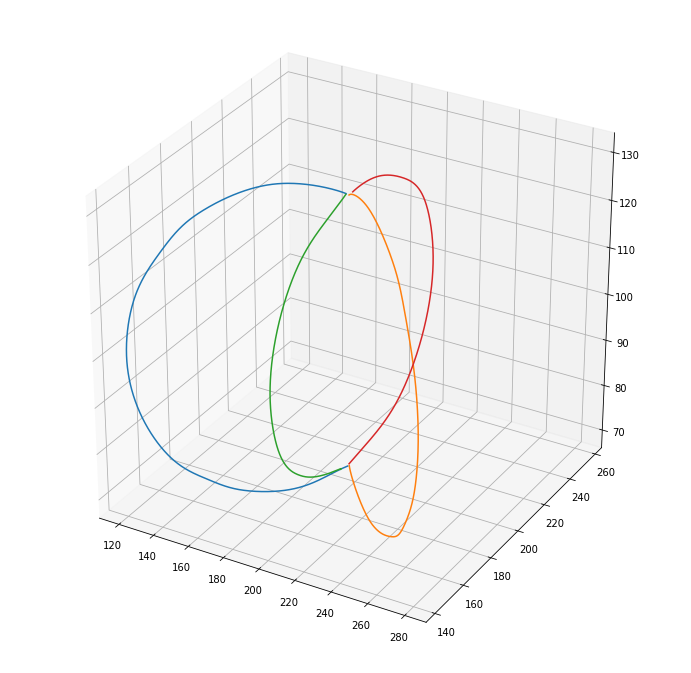

In [15]:
### Visualize the fitted splines as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ spline in a different color
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.plot(TJs_splev[TJ_ID][:,2], 
               TJs_splev[TJ_ID][:,1], 
               TJs_splev[TJ_ID][:,0],)
               #c=[TJ_num for _ in range(TJs_splev[TJ_ID].shape[0])], 
               #cmap='hsv', vmin=0, vmax=len(TJs), s=10)

## Axis limits
#ax.set_xlim([0,400])
#ax.set_ylim([0,400])
#ax.set_zlim([0,400])  # NOTE: RESULT IS SQUASHED IF RESOLUTION IS NOT CONSIDERED!

# Finish
plt.show()

### Retrieving Incident Vectors (Our Approach)

Instead of first computing incident vectors for each TE in the image sectioning planes and then projecting them onto the corresponding orthogonal plane, we here attempt to compute the incident vectors directly based on the outline points close to said orthogonal plane.

In [16]:
### Sympy function to project close-by outline points onto a TE's orthogonal plane
### Note: this should be encoded so it doesn't need to be run by the end user!

# Import sympy stuff
import sympy as sym
from sympy.abc import q,r,s,  x,y,z  # (normal vector), (point to be projected)

# Use Gram-Schmidt orthogonalization to create orthonormal vectors defining the in-plane
# coordinate system given three arbitrary vectors, the first of which is the normal vector
# of the plane. The other two (defining the in-plane directionalities) are arbitrarily 
# chosen such that they will never fall onto the normal vector or onto each other.
orthonormals = sym.GramSchmidt([sym.Matrix([q,    r,  s]),  # Normal vector to plane -> first coordinate vector
                                sym.Matrix([q,  2*r,3*s]),  # Arbitrary vector not on the normal vector
                                sym.Matrix([2*q,3*r,  s])], # Arbitrary vector not on either other vector
                                orthonormal=True)           # Normalize resulting orthogonal vectors

# With the orthonormals defining the new coordinate system, the projection of points
# into it is just a straightforward dot product.
projection_pt = sym.Matrix([x, y, z])
proj_d = orthonormals[0].dot(projection_pt)  # Distance from plane
proj_u = orthonormals[1].dot(projection_pt)  # Coordinate along first axis in plane
proj_v = orthonormals[2].dot(projection_pt)  # Coordinate along second axis in plane

# Lambdify
lambda_dist = sym.utilities.lambdify((q,r,s,x,y,z), proj_d, modules='numpy')
lambda_u    = sym.utilities.lambdify((q,r,s,x,y,z), proj_u, modules='numpy')
lambda_v    = sym.utilities.lambdify((q,r,s,x,y,z), proj_v, modules='numpy')

# Wrap
def p2p_projection(normal_vec, pt_coords):
    
    # Unpack inputs
    q,r,s = normal_vec[0], normal_vec[1], normal_vec[2]
    z,y,x = pt_coords[:,0], pt_coords[:,1], pt_coords[:,2]
    
    # Run projection
    dists = np.abs(lambda_dist(q,r,s,x,y,z))
    p_u   = lambda_u(q,r,s,x,y,z)
    p_v   = lambda_v(q,r,s,x,y,z)
    
    # Pack and return outputs
    projected = np.array([p_u, p_v]).T
    return projected, dists

In [17]:
### Function to fit incident vectors for a TE

# TODO!

In [18]:
### Perform incident vector fitting for all TEs

# Parameters
query_range = 20

# Prep KDTree
kdtree = spatial.cKDTree(OCs)

# For each TJ...
for TJ_ID in list(TJs.keys()):
    
    # Grab the TE and tangent vectors (normals)
    TJ = TJs_splev[TJ_ID]
    normal_vecs = TJs_spltng[TJ_ID]
    
    # Get close-by points for each TE
    SNNs = kdtree.query_ball_point(TJs_splev[TJ_ID], query_range)
    
    # Project close-by points and fit vectors
    all_projected = []
    all_dists     = []
    for normal_vec, SNN, TE in zip(normal_vecs, SNNs, TJ):
        
        # Grab coords and translate them such that the TE is at (0,0,0)
        SNN_coords = OCs[SNN] - TE
        
        # Project close-by points to the plane
        projected, dists = p2p_projection(normal_vec, SNN_coords)
        all_projected.append(projected)
        all_dists.append(dists)
        
        # Fit the incident vectors
        # TODO!
    
    break

In [19]:
### Visualize view in plane

@interact(TE_num=(0,99,1), dist_thresh=(0,100,1))
def visualize_plane(TE_num=50, dist_thresh=50):

    # Prep
    plt.figure(figsize=(12,9))

    # Plot points
    dist_mask = all_dists[TE_num]<np.percentile(all_dists[TE_num], dist_thresh)
    plt.scatter(all_projected[TE_num][dist_mask,0], 
                all_projected[TE_num][dist_mask,1], 
                c=all_dists[TE_num][dist_mask],
                s=20, alpha=0.8, linewidth=0)
    plt.colorbar(label='distance')

    # Mark origin
    plt.scatter(0, 0, c='r', s=100, linewidth=0)

    # Label
    plt.xlabel('u')
    plt.ylabel('v')

    # Done
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=50, description='TE_num', max=99), IntSlider(value=50, description='dist…

In [20]:
### Visualize in 3D context

@interact(TE_num=(0,99,1))
def visualize_plane(TE_num=50):

    # Prepare the plot
    fig = plt.figure(figsize=(12,12))
    ax  = fig.add_subplot(111, projection='3d')

    # Plot each TJ spline in a different color
    for TJ_num,TJ_ID in enumerate(TJs.keys()):
        ax.scatter(TJs_splev[TJ_ID][:,2], 
                   TJs_splev[TJ_ID][:,1], 
                   TJs_splev[TJ_ID][:,0],
                   c=[TJ_num for _ in range(TJs_splev[TJ_ID].shape[0])], 
                   cmap='hsv', vmin=0, vmax=len(TJs), s=10)

    ## Also show cell outlines [takes a few seconds to render!]
    #ax.scatter([c[2] for c in OCs],
    #           [c[1] for c in OCs],
    #           [c[0] for c in OCs],
    #           c='gray', alpha=0.05, linewidth=0, s=5)

    # Show the selected points
    ax.scatter(OCs[SNNs[TE_num],2], OCs[SNNs[TE_num],1], OCs[SNNs[TE_num],0],
               c='green', alpha=0.5, linewidth=0, s=5)

    ## Axis limits
    #ax.set_xlim([0,400])
    #ax.set_ylim([0,400])
    #ax.set_zlim([0,400]) 

    # Finish
    plt.show()

interactive(children=(IntSlider(value=50, description='TE_num', max=99), Output()), _dom_classes=('widget-inte…

### Retrieving Incident Vectors (Brodland Approach)

In [21]:
### Build a dict of all dual interfaces structured as: {tuple(cell1_ID) : array(OCs, Dimensions)}

# Prepare defaultdict
from collections import defaultdict
ICs = defaultdict(lambda : [[],[],[]])  # ICs <- "Interface Coordinates"

# Go through OCs, create IDs, assign coordinates to IDs
for OC in OCs:
    selection = im_pad[np.int(OC[0])+1:np.int(OC[0])+3, 
                       np.int(OC[1])+1:np.int(OC[1])+3, 
                       np.int(OC[2])+1:np.int(OC[2])+3]
    IC_ID = tuple(sorted(set(selection.flatten())))
    if len(IC_ID) >= 2:
        ICs[IC_ID][0].append(OC[0])
        ICs[IC_ID][1].append(OC[1])
        ICs[IC_ID][2].append(OC[2])

# Convert IC lists to numpy arrays
for key in ICs.keys():
    ICs[key] = np.array(ICs[key]).T

In [22]:
### Show ICs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each IC...
    for IC_num,IC_ID in enumerate(ICs.keys()):
        
        # Get the IC's OCs in the selected z plane
        OCs_in_plane = ICs[IC_ID][np.floor(ICs[IC_ID][:,0])==z]
        
        # Plot the points (note the curios way of setting the color!)
        plt.scatter(OCs_in_plane[:, 2], OCs_in_plane[:, 1],
                    c=[IC_num for _ in range(OCs_in_plane.shape[0])], 
                    cmap='hsv', vmin=0, vmax=len(ICs), s=20)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [ ]:
### Identify unique TE points in each z-slice

# Params
same_TE_radius = 15.0

# Prepare dicts
z_TJs  = {}  # TJs accessible by z plane
z_uTJs = {}  # TJs with a unique TE point accessible by z plane
uTJS   = {}  # TJs with a unique TE point

# For each slice...
for z in range(im.shape[0]):
    
    # Prep containers
    z_TJs[z] = {}
    z_uTJs[z] = {}
    
    # For each TJ...
    for TJ_num,TJ_ID in enumerate(TJs.keys()):
        
        # Get TEs in the current plane for the current TJ
        TEs_in_plane = TJs[TJ_ID][np.floor(TJs[TJ_ID][:,0])==z]
        if TEs_in_plane.size > 0:
            z_TJs[z][TJ_ID] = TEs_in_plane
        
            # There may be more than one TE point in a plane;
            # find such instances and use their centroid instead!
            # NOTE: This is currently done in a somewhat simplistic manner
            #       based on nearest neighbors within a given radius. It
            #       could probably be improved a bit later.
            # NOTE: Another good option would be to use the TJ spline
            #       instead - if there's an easy way to find xy for a
            #       given value of z.
            z_uTJs[z][TJ_ID] = []
            while TEs_in_plane.size > 0:
                kdtree = spatial.cKDTree(TEs_in_plane)
                KNNs   = kdtree.query_ball_point(TEs_in_plane[0], same_TE_radius)
                centroid = TEs_in_plane[KNNs].mean(axis=0)
                z_uTJs[z][TJ_ID].append(centroid)
                TEs_in_plane = TEs_in_plane[np.in1d(np.arange(TEs_in_plane.shape[0]), 
                                                    KNNs, invert=True)]
                
# Convert to arrays 
for z in range(im.shape[0]):
    for TJ_ID in z_TJs[z].keys():
        z_uTJs[z][TJ_ID] = np.array(z_uTJs[z][TJ_ID])

In [24]:
### Show unique TEs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # Plot TJs in this z plane
    TJs_in_plane = z_uTJs[z]
    for TJ_num,TJ_ID in enumerate(TJs_in_plane.keys()):        
        plt.scatter(TJs_in_plane[TJ_ID][:, 2], TJs_in_plane[TJ_ID][:, 1],
                    c=[TJ_num for _ in range(TJs_in_plane[TJ_ID].shape[0])], 
                    cmap='hsv', vmin=0, vmax=len(ICs), s=20)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [25]:
### Functions for circular arc fitting 

def circle(r, cx, cy, alpha):
    x = r*np.cos(alpha) + cx
    y = r*np.sin(alpha) + cy
    return np.array([x,y])

def loss(params, x, y):
    r, cx, cy = params
    loss = np.sqrt((x-cx)**2 + (y-cy)**2) - r
    return np.sum(loss**2)

def wrap_sub(n1, n2, minimum=-np.pi, maximum=np.pi):
    s = n1 - n2 
    try:
        s[s<=minimum] = maximum + (s[s<=minimum] - minimum)
        s[s>=maximum] = minimum + (s[s>=maximum] - maximum)
    except TypeError:
        if s <= minimum: s = maximum + (s - minimum)
        if s >= maximum: s = minimum + (s - maximum)
    return s

In [26]:
### Find incident vectors for each unique TE point

# Params
close_points_radius = 25.0

# Output
TJs_vec = defaultdict(lambda : [])
TJs_vec_raw = defaultdict(lambda : [])
z_TJs_vec = {}
z_TJs_vec_raw = {}

# For each slice...
for z in range(im.shape[0]):
    z_TJs_vec[z] = defaultdict(lambda : [])
    z_TJs_vec_raw[z] = defaultdict(lambda : [])
    
    # For each TJ present in the slice...
    for TJ_ID in z_TJs[z].keys():
        
        # Find IDs of connected interfaces
        IC_IDs = list(itertools.combinations(TJ_ID, 2))
        
        # Skip cases with more than 3
        if len(IC_IDs) > 3:
            continue
        
        # For each unique TE of the TJ...
        for uTE in z_uTJs[z][TJ_ID]:
            
            # Add a result array to the TJ
            TJs_vec[TJ_ID].append(np.empty((3,3)))
            TJs_vec[TJ_ID][-1][:,0] = z
            TJs_vec_raw[TJ_ID].append(np.empty((3,3)))
            TJs_vec_raw[TJ_ID][-1][:,0] = z
            z_TJs_vec[z][TJ_ID].append(np.empty((3,2)))
            z_TJs_vec_raw[z][TJ_ID].append(np.empty((3,2)))
            
            # For each interface connected to the unique TE...
            base_alpha = None
            skip = False
            for IC_idx, IC_ID in enumerate(IC_IDs):
                
                # Get all points from the interface at this z, skip if none
                ICs_connected = ICs[IC_ID][np.floor(ICs[IC_ID][:,0])==z]
                if ICs_connected.size == 0:
                    TJs_vec[TJ_ID][-1].fill(np.nan)
                    TJs_vec_raw[TJ_ID][-1].fill(np.nan)
                    z_TJs_vec[z][TJ_ID][-1].fill(np.nan)
                    z_TJs_vec_raw[z][TJ_ID][-1].fill(np.nan)
                    skip = True
                    print("Skipped TE at z="+str(z)+", TJ_ID+"+str(TJ_ID)+" -> no connected ICs!")
                    break
                
                # Get the closest points
                kdtree = spatial.cKDTree(ICs_connected)
                KNNs   = kdtree.query_ball_point(uTE, close_points_radius)
                
                # In exceptional cases without neighbors, skip this TE
                if not KNNs:
                    TJs_vec[TJ_ID][-1].fill(np.nan)
                    TJs_vec_raw[TJ_ID][-1].fill(np.nan)
                    z_TJs_vec[z][TJ_ID][-1].fill(np.nan)
                    z_TJs_vec_raw[z][TJ_ID][-1].fill(np.nan)
                    skip = True
                    print("Skipped TE at z="+str(z)+", TJ_ID+"+str(TJ_ID)+" -> no neighbors!")
                    break
                    
                # Fit a circle
                x = np.concatenate([ICs_connected[KNNs,2], uTE[2,np.newaxis]])
                y = np.concatenate([ICs_connected[KNNs,1], uTE[1,np.newaxis]])
                with np.errstate(divide='ignore'):
                    fit = optimize.minimize(loss, [1.0, np.mean(x), np.mean(y)], args=(x, y))
                    # NOTE: When all points are EXACTLY in a straight line, this has an unwanted
                    #       local minimum and will give the wrong result!
                r, cx, cy = fit.x

                # If there is no base angle yet, get it
                if base_alpha is None:
                    base_alpha = np.arctan2(uTE[1]-cy, uTE[2]-cx)

                # Get angle for projected TE and rotate by base angle
                TE_alpha_raw = np.arctan2(uTE[1]-cy, uTE[2]-cx)
                TE_alpha = wrap_sub(TE_alpha_raw, base_alpha)

                # Get correct sign for tangent vector direction
                ICs_alpha = wrap_sub(np.arctan2(y-cy, x-cx), base_alpha)
                ICs_alpha = wrap_sub(ICs_alpha, TE_alpha)
                sign = np.sign(np.mean(ICs_alpha))

                # Get tangent vector based on TE angle and shift
                # WITHOUT base angle correction
                TE_proj_raw = circle(r, cx, cy, TE_alpha_raw)[::-1]
                shifted_raw = circle(r, cx, cy, TE_alpha_raw+10e-5)[::-1]
                tangent_raw = shifted_raw - TE_proj_raw
                tangent_raw = tangent_raw * sign
                
                # Get tangent vector based on TE angle and shift
                # WITH base angle correction
                TE_proj = circle(r, cx, cy, TE_alpha)[::-1]
                shifted = circle(r, cx, cy, TE_alpha+10e-5)[::-1]
                tangent = shifted - TE_proj
                tangent = tangent * sign
                
                # Normalize to magnitude 1
                tangent_raw = tangent_raw / np.sqrt(np.sum(tangent_raw**2.0))
                tangent = tangent / np.sqrt(np.sum(tangent**2.0))
                
                # Save the results
                TJs_vec[TJ_ID][-1][IC_idx, 1:] = tangent
                TJs_vec_raw[TJ_ID][-1][IC_idx, 1:] = tangent_raw
                z_TJs_vec[z][TJ_ID][-1][IC_idx] = tangent
                z_TJs_vec_raw[z][TJ_ID][-1][IC_idx] = tangent_raw
                
            # Handle skipping cases
            if skip:
                continue
                
# Convert to array
for TJ_ID in TJs_vec.keys():
    TJs_vec[TJ_ID] = np.array(TJs_vec[TJ_ID])
    TJs_vec_raw[TJ_ID] = np.array(TJs_vec_raw[TJ_ID])

Skipped TE at z=71, TJ_ID+(0, 1, 2) -> no neighbors!
Skipped TE at z=71, TJ_ID+(0, 1, 3) -> no neighbors!
Skipped TE at z=71, TJ_ID+(1, 2, 3) -> no connected ICs!
Skipped TE at z=71, TJ_ID+(0, 2, 3) -> no connected ICs!
Skipped TE at z=71, TJ_ID+(0, 2, 3) -> no connected ICs!
Skipped TE at z=128, TJ_ID+(0, 1, 2) -> no neighbors!
Skipped TE at z=128, TJ_ID+(0, 1, 3) -> no neighbors!
Skipped TE at z=128, TJ_ID+(1, 2, 3) -> no connected ICs!
Skipped TE at z=128, TJ_ID+(0, 2, 3) -> no connected ICs!


In [27]:
### Visualize the resulting vectors

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # Plot vectors in this plane
    TJs_in_plane  = z_uTJs[z]
    Vecs_in_plane = z_TJs_vec_raw[z]
    for TJ_num,TJ_ID in enumerate(TJs_in_plane.keys()):
        for TJ,TJ_vec in zip(TJs_in_plane[TJ_ID],Vecs_in_plane[TJ_ID]):
            plt.plot([TJ[2], TJ[2]+TJ_vec[0,1]*10], 
                     [TJ[1], TJ[1]+TJ_vec[0,0]*10],
                     'r-', lw=2)
            plt.plot([TJ[2], TJ[2]+TJ_vec[1,1]*10], 
                     [TJ[1], TJ[1]+TJ_vec[1,0]*10],
                     'r-', lw=2)
            plt.plot([TJ[2], TJ[2]+TJ_vec[2,1]*10], 
                     [TJ[1], TJ[1]+TJ_vec[2,0]*10],
                     'r-', lw=2)
        
    # Finish
    #plt.xlim([100,150])
    #plt.ylim([110,160])
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

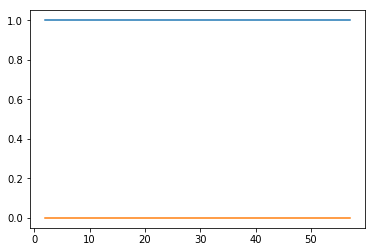

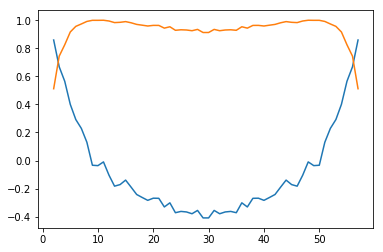

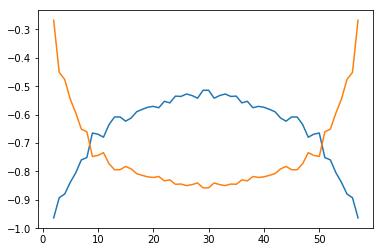

In [28]:
#plt.plot(TJs_vec[TJ_ID][:,0,0])
plt.plot(TJs_vec[TJ_ID][:,0,1])
plt.plot(TJs_vec[TJ_ID][:,0,2])
plt.show()
#plt.plot(TJs_vec[TJ_ID][:,1,0])
plt.plot(TJs_vec[TJ_ID][:,1,1])
plt.plot(TJs_vec[TJ_ID][:,1,2])
plt.show()
#plt.plot(TJs_vec[TJ_ID][:,2,0])
plt.plot(TJs_vec[TJ_ID][:,2,1])
plt.plot(TJs_vec[TJ_ID][:,2,2])
plt.show()

In [29]:
### Project vectors onto the TJ-orthogonal plane (using Vivek's p2p projection)

# For each available TJ...
TJs_vec_proj = defaultdict(lambda : [])
for TJ_ID in TJs_vec_raw.keys():
    
    # Find the closest point to the unique TEs on the spline
    # NOTE: We should detect unique TEs at the beginning and then directly
    #       do the spline fitting on those!
    tck = TJs_spltck[TJ_ID]
    ev = interpolate.splev(np.linspace(0.0, 1.0, 1000), tck)
    ev = np.array(ev).T
    uTEs = []
    for z in range(im.shape[0]):
        if TJ_ID in list(z_uTJs[z].keys()):
            uTE = z_uTJs[z][TJ_ID]
            if uTE.ndim == 1:
                uTEs.append(uTE)
            else:
                for u in uTE:
                    uTEs.append(u)
    uTEs = np.array(uTEs)
    uTEs = uTEs[TJs_splord[TJ_ID]]  # Sort to same order as spline
    kdtree = spatial.cKDTree(ev)
    _, idx = kdtree.query(uTEs, k=1)
                    
    # Get the tangent vectors corresponding to the TEs
    evD1 = np.array(interpolate.splev(np.linspace(0.0, 1.0, 1000)[idx]+10e-5, tck)).T
    evD2 = np.array(interpolate.splev(np.linspace(0.0, 1.0, 1000)[idx]-10e-5, tck)).T
    tangent_vecs = (evD1 - ev[idx]) + (ev[idx] - evD2)
    
    #print(ev.shape, ev[idx].shape, idx.shape)
    #
    #plt.scatter(ev[idx,0], evD2[:,0])
    #plt.axis('equal')
    #plt.show()
    #plt.scatter(ev[idx,1], evD2[:,1])
    #plt.axis('equal')
    #plt.show()
    #plt.scatter(ev[idx,2], evD2[:,2])
    #plt.axis('equal')
    #plt.show()
    #
    #plt.plot(tangent_vecs[:,-1]) # FIXME: Something is very weird here...
    #plt.plot(tangent_vecs[:,-2]) # ...and something else may be weird here...
    #plt.plot(tangent_vecs[:,-3]) # ...and here!  ->> Reckon something is weird in the two paragraphs above?!
    #plt.show()
    
    # Project the vectors to the normal plane
    all_projected = []
    for normal, vecs in zip(tangent_vecs, TJs_vec_raw[TJ_ID]):
        print(normal.shape, vecs.shape)
        print(vecs)
        projected, dists = p2p_projection(normal, vecs)
        projected = projected / np.sqrt(np.sum(projected**2.0, axis=1))[:,np.newaxis]
        all_projected.append(projected)
    all_projected = np.array(all_projected)

    # Save the results
    TJs_vec_proj[TJ_ID] = all_projected

IndexError: index 99 is out of bounds for axis 0 with size 76

In [ ]:
for TJ_ID in TJs_vec_proj.keys():
    print('\n\n', TJ_ID)
    plt.plot(TJs_vec_proj[TJ_ID][:,0,0])
    plt.plot(TJs_vec_proj[TJ_ID][:,0,1])
    plt.show()
    plt.plot(TJs_vec_proj[TJ_ID][:,1,0])
    plt.plot(TJs_vec_proj[TJ_ID][:,1,1])
    plt.show()
    plt.plot(TJs_vec_proj[TJ_ID][:,2,0])
    plt.plot(TJs_vec_proj[TJ_ID][:,2,1])
    plt.show()

# ->> Why do these turn out so completely wrong????

### <font color=red>YAH!</font>

- At `TJs_vec_raw` to be computed during incident vector retrieval and replace `TJ_vec` with it in the 2p2 projection.
    - Make sure the z component is included correctly!
- Reduce/reimplement (somewhere above?) the generation of `uTEs` instead of `z_uTEs`
    - Make sure they map to each other correctly!
- Double-check/fix/debug the projection as needed until the results are reasonable
- See how to do the 'registration' of projected vectors onto the first vector
    - `arctan2 -> subtract base angle -> circle(1, 0, 0, angles)` may be the way to go for this
- Check the consistency of the results again and get a simple consensus for each TJ

### Next Up / To Do

- Our approach
    - Label/select the plane-projected points based on the interface they belong to [->> Vivek]
    - Fit a line/spline/arc through each set of projected interface points


- Brodland approach
    - Fit splines to each (relevant) outline in each z-slice [->> Harsh]
        - Only run this for each relevant TE in a given z-slice
        - Speed up pre-spline sorts by using the TEs as source points
    - Use the splines to get angles/vectors for TEs
    - Project the resulting vectors onto the corresponding normal planes
    

- Both approaches
    - Look at the resulting set of angles/vectors and see how to consolidate/average them (whilst enforcing consistency)
        - Truncate endings, as they are often messy
        - Entirely trash very short TJs (do this early on)
        - Look at the remaining angles/vectors and see how best to clean/average them
        - Consider using the residuals from the line/spline/arc fits somehow to weigh contributions
    - Proceed to use the resulting angles/vectors for equation solving